In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import pandas as pd
from torch.utils.data import Dataset
import os
from PIL import Image
from sklearn.model_selection import train_test_split #to create testing and train
import matplotlib.pyplot as plt #used to print image
from torchvision import transforms
import optuna
import torch.nn as nn

# Lab for Week 5: Fitting a Feed Forward Neural Network

In Milestone 1 you chose a project topic you are interested in and found some datasets you could use. You also already built a [data loader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).

Today, we will fit a baseline feed forward neural network to one of the datasets you chose by following the pytorch tutorials.

## Step 1: Define a Data Loader
You are encouraged to use one of the data loaders you built for milestone 1. Otherwise use the one described [here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).

Tip: If your targets are labels, you might want to use the lambda transformation described [here](https://pytorch.org/tutorials/beginner/basics/transforms_tutorial.html) to turn your target into one-hot vectors.

In [2]:
fitzpatrick_url = 'https://raw.githubusercontent.com/mattgroh/fitzpatrick17k/refs/heads/main/fitzpatrick17k.csv'
fitzpatrick_df = pd.read_csv(fitzpatrick_url)
image_path = '/Users/laureladams/Documents/School/spring2025/introtoADL/Intro2ADL/processed_images' #change this for your image path

In [3]:
class CustomDataset(Dataset):
    def __init__(self, data, image_dir, transform=None):
        #self.data = data.reset_index(drop=True) #to reset the index. May not be necessary, trying to debug
        self.data = data.dropna(subset=['md5hash', 'url', 'fitzpatrick_scale', 'label']) # drop any relevant columns iwth na values.
        self.image_dir = image_path #image path
        self.transform = transform
        
        if self.data['label'].dtype == 'object':  # This part is to convert the disease classifications to numerical values
            self.label_mapping = {label: idx for idx, label in enumerate(self.data['label'].unique())}
            self.data.loc[:,'label'] = self.data['label'].map(self.label_mapping) 
        
        self.data = self.data[self.data['md5hash'].apply(self._image_exists)]
        # print(self.data.dtypes)
        
    def _image_exists(self, md5hash):
        """Helper function to check if image exists."""
        img_filename = md5hash + ".jpg"
        img_path = os.path.join(self.image_dir, img_filename)
        return os.path.exists(img_path)
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # construct the image file name fromm teh md5hash column plus .jpg ending
        img_filename = self.data.iloc[idx]['md5hash']+ ".jpg"
        img_path = os.path.join(self.image_dir, img_filename)
        
#         if not os.path.exists(img_path):
#             print(f"Image not found: {img_path}")
#             # Optionally return a placeholder or an empty image tensor if you want to skip these samples
#             placeholder_image = Image.new('RGB', (299, 299))  # Create a dummy image
#             return placeholder_image, torch.tensor(0.0), torch.tensor(0)
        image = Image.open(img_path).convert('RGB') #make sure image is converted to RGB
        
        if self.transform:
            image = self.transform(image)
            
            
        
        #Get Fitzpatrick value as input feature
        fitzpatrick_value = torch.tensor(self.data.iloc[idx]['fitzpatrick_scale'], dtype=torch.float32)
       
        #Get skin condition label as output
        label = torch.tensor(self.data.iloc[idx]['label'], dtype=torch.long)
        
        #image_and_fitzpatrick = torch.cat((image, fitzpatrick_value.view(1, 1, 1).expand(1, image.shape[1], image.shape[2])), dim=0)
        
        return image, fitzpatrick_value, label  #returns image and fitzpatrick value as input


In [4]:
transform = transforms.Compose([
    transforms.ToTensor()
])
    
# Create dataset
dataset = CustomDataset(fitzpatrick_df, image_path)
print(len(dataset))

#define dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

#create train and test sets
df_train, df_test = train_test_split(fitzpatrick_df, test_size=0.2, random_state=42)

train_dataset = CustomDataset(df_train, image_path, transform=transform)
test_dataset = CustomDataset(df_test, image_path, transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=64)
test_dataloader = DataLoader(test_dataset, batch_size=64)

print(len(train_dataloader))
print(len(test_dataloader))

16518
207
52


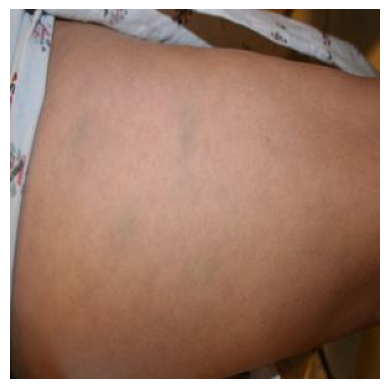

Fitzpatrick Value: 3.0
Label: 0


In [5]:

# THIS CELL is just to test that the dataset is loaded properly

# Gets the first item from the dataset
image, fitzpatrick_value, label = dataset[0]
# Displays an image
plt.imshow(image)
plt.axis('off')  # Axis isn't necessary
plt.show()
print(f'Fitzpatrick Value: {fitzpatrick_value.item()}')
print(f'Label: {label.item()}')

## Step 2: Define a Model
Follow [this tutorial](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html) to define a model. Make sure that the input dimension fits the dimensionality of your data, and the output dimension fits the dimensionality of your targets.

In [6]:
class NeuralNetwork(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super().__init__()
        
        self.Flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            #nn.Linear(299*299 + 1, 512),
            nn.Linear(268204, 512),
            nn.BatchNorm1d(512), #batchnorm implementation
            nn.ReLU(),
            nn.Dropout(p=dropout_rate), #Dropout rate
            nn.Linear(512, 512),
            nn.BatchNorm1d(512), #batchnorm implementation
            nn.ReLU(),
            nn.Dropout(p=dropout_rate), #dropout for second linear layer
            nn.Linear(512, 114), #output layer is set to 114 for 114 (skin type/disease) classifications 
        )

    def forward(self, x, fv):
        #print(x.shape)
        x = self.Flatten(x)
        #print(x.shape) #debugging
        x = torch.cat((x, fv.view(-1,1)), dim=1) 
        logits = self.linear_relu_stack(x)
        return logits

In [7]:
model = NeuralNetwork()
print(model)

NeuralNetwork(
  (Flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=268204, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=512, out_features=114, bias=True)
  )
)


## Step 3: Train Model

Follow the tutorial [here](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html) to train your model.

In [8]:
def train_loop(dataloader, model, loss_fn, optimizer):
    """
    Runs one full training epoch on the given model using the provided dataloader.

    Parameters:
        dataloader (torch.utils.data.DataLoader): DataLoader providing batches of training data (inputs and labels).
        model (torch.nn.Module): The PyTorch model to be trained.
        loss_fn (function): The loss function used to compute the error between predictions and true labels.
        optimizer (torch.optim.Optimizer): The optimizer used to update the model parameters.

    Behavior:
        - Sets the model to training mode (important for layers like dropout and batch normalization).
        - Iterates over the data batches:
            - Computes the model's predictions.
            - Calculates the loss.
            - Performs backpropagation and updates model weights.
        - Prints progress every 100 batches, showing the current loss and the number of samples processed.

    Returns:
        None
    """
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, fv, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X, fv)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
  

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    """
    Evaluates the model's performance on a test dataset.

    Parameters:
        dataloader (torch.utils.data.DataLoader): DataLoader providing batches of test data (inputs and labels).
        model (torch.nn.Module): The PyTorch model to be evaluated.
        loss_fn (function): The loss function used to compute the error between predictions and true labels.

    Behavior:
        - Sets the model to evaluation mode (which disables behaviors like dropout).
        - Iterates over the test data without computing gradients (using torch.no_grad() for efficiency).
        - Accumulates the total loss and counts the number of correct predictions.
        - Computes the average loss and overall accuracy.
        - Prints the test accuracy and average loss.

    Returns:
        None
    """ 
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, fv, y in dataloader:
            pred = model(X, fv)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")






In [9]:
 print(fitzpatrick_df['md5hash'].head())


0    5e82a45bc5d78bd24ae9202d194423f8
1    fa2911a9b13b6f8af79cb700937cc14f
2    d2bac3c9e4499032ca8e9b07c7d3bc40
3    0a94359e7eaacd7178e06b2823777789
4    a39ec3b1f22c08a421fa20535e037bba
Name: md5hash, dtype: object


In [10]:
#debugging missing images issue
target_md5hash = '23575178ed245ee186aa5f64c94b48d9'
url_value = fitzpatrick_df.loc[fitzpatrick_df['md5hash'] == target_md5hash, 'url'].values[0]
print(url_value)

http://atlasdermatologico.com.br/img?imageId=5060


In [11]:
#debugging missing images issue
target_md5hash = '5e82a45bc5d78bd24ae9202d194423f8'
url_value = fitzpatrick_df.loc[fitzpatrick_df['md5hash'] == target_md5hash, 'url'].values[0]
print(url_value)

https://www.dermaamin.com/site/images/clinical-pic/m/minocycline-pigmentation/minocycline-pigmentation1.jpg


In [ ]:
# Train the model for 3 different hyper parameter settings (e.g. different learning rates, different loss functions that make sense for your data, etc.)
learning_rate = 1e-3
batch_size = 64
epochs = 10

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")


In [14]:
def objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.3, 0.7)
    
    model = NeuralNetwork(dropout_rate=dropout_rate)
    
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    loss_fn = nn.CrossEntropyLoss()
    
    for epoch in range(3):
        train_loop(train_dataloader, model, loss_fn, optimizer)
        
    val_loss = test_loop(test_dataloader, model, loss_fn)
    
    return val_loss

study = optuna.create_study(direction ='minimize') #minimize validation loss
study.optimize(objective, n_trials=100)

study.best_params  # E.g. {'x': 2.002108042}

[I 2025-03-18 15:24:56,911] A new study created in memory with name: no-name-686ba1e4-55e1-415b-b22a-890f8f380051


loss: 4.933369  [   64/13216]
loss: 4.845496  [ 6464/13216]
loss: 4.774834  [12864/13216]
loss: 4.662963  [   64/13216]
loss: 4.690387  [ 6464/13216]
loss: 4.512093  [12864/13216]
loss: 4.434472  [   64/13216]
loss: 4.713515  [ 6464/13216]
loss: 4.616922  [12864/13216]


[W 2025-03-18 15:27:28,652] Trial 0 failed with parameters: {'learning_rate': 0.0008636819993212143, 'dropout_rate': 0.4616848944818662} because of the following error: The value None could not be cast to float..
[W 2025-03-18 15:27:28,653] Trial 0 failed with value None.


Test Error: 
 Accuracy: 1.1%, Avg loss: 4.774691 

loss: 4.820707  [   64/13216]
loss: 4.754196  [ 6464/13216]
loss: 4.706070  [12864/13216]
loss: 4.622287  [   64/13216]
loss: 4.649264  [ 6464/13216]
loss: 4.670441  [12864/13216]
loss: 4.642996  [   64/13216]
loss: 4.624976  [ 6464/13216]
loss: 4.608791  [12864/13216]


[W 2025-03-18 15:29:58,862] Trial 1 failed with parameters: {'learning_rate': 0.0007914361320247982, 'dropout_rate': 0.4664518090210692} because of the following error: The value None could not be cast to float..
[W 2025-03-18 15:29:58,862] Trial 1 failed with value None.


Test Error: 
 Accuracy: 0.8%, Avg loss: 4.792442 

loss: 4.890284  [   64/13216]
loss: 4.939853  [ 6464/13216]
loss: 4.882697  [12864/13216]
loss: 4.793589  [   64/13216]
loss: 4.890685  [ 6464/13216]
loss: 4.752972  [12864/13216]
loss: 4.662431  [   64/13216]
loss: 4.823492  [ 6464/13216]
loss: 4.762441  [12864/13216]


[W 2025-03-18 15:32:29,360] Trial 2 failed with parameters: {'learning_rate': 0.00016073284741355726, 'dropout_rate': 0.5018368389019227} because of the following error: The value None could not be cast to float..
[W 2025-03-18 15:32:29,361] Trial 2 failed with value None.


Test Error: 
 Accuracy: 0.7%, Avg loss: 4.802623 

loss: 4.792383  [   64/13216]
loss: 4.749110  [ 6464/13216]
loss: 4.690145  [12864/13216]
loss: 4.461967  [   64/13216]
loss: 4.757193  [ 6464/13216]
loss: 4.631503  [12864/13216]
loss: 4.473589  [   64/13216]
loss: 4.483403  [ 6464/13216]
loss: 4.556892  [12864/13216]


[W 2025-03-18 15:35:08,405] Trial 3 failed with parameters: {'learning_rate': 0.0006109580419135156, 'dropout_rate': 0.35647548251710987} because of the following error: The value None could not be cast to float..
[W 2025-03-18 15:35:08,406] Trial 3 failed with value None.


Test Error: 
 Accuracy: 1.1%, Avg loss: 4.838826 

loss: 4.892931  [   64/13216]
loss: 4.710866  [ 6464/13216]
loss: 4.840449  [12864/13216]
loss: 4.750508  [   64/13216]
loss: 4.707861  [ 6464/13216]
loss: 4.768957  [12864/13216]
loss: 4.845270  [   64/13216]
loss: 4.694279  [ 6464/13216]
loss: 4.776949  [12864/13216]


[W 2025-03-18 15:37:58,885] Trial 4 failed with parameters: {'learning_rate': 1.0626149748213674e-05, 'dropout_rate': 0.3048401013169597} because of the following error: The value None could not be cast to float..
[W 2025-03-18 15:37:58,886] Trial 4 failed with value None.


Test Error: 
 Accuracy: 1.2%, Avg loss: 4.779526 

loss: 4.805614  [   64/13216]
loss: 4.784705  [ 6464/13216]
loss: 4.546857  [12864/13216]
loss: 4.278103  [   64/13216]
loss: 4.592258  [ 6464/13216]
loss: 4.467168  [12864/13216]
loss: 4.211493  [   64/13216]
loss: 4.627549  [ 6464/13216]
loss: 4.325460  [12864/13216]


[W 2025-03-18 15:40:43,115] Trial 5 failed with parameters: {'learning_rate': 0.003974989327393979, 'dropout_rate': 0.32870658429681443} because of the following error: The value None could not be cast to float..
[W 2025-03-18 15:40:43,116] Trial 5 failed with value None.


Test Error: 
 Accuracy: 1.2%, Avg loss: 4.906529 

loss: 4.892807  [   64/13216]
loss: 4.836601  [ 6464/13216]
loss: 4.791637  [12864/13216]
loss: 4.793494  [   64/13216]
loss: 4.756404  [ 6464/13216]
loss: 4.751267  [12864/13216]
loss: 4.640067  [   64/13216]
loss: 4.777778  [ 6464/13216]
loss: 4.691725  [12864/13216]


[W 2025-03-18 15:43:28,065] Trial 6 failed with parameters: {'learning_rate': 0.00015877245628897774, 'dropout_rate': 0.42045979939420053} because of the following error: The value None could not be cast to float..
[W 2025-03-18 15:43:28,067] Trial 6 failed with value None.


Test Error: 
 Accuracy: 0.8%, Avg loss: 4.795084 

loss: 5.033706  [   64/13216]
loss: 4.932906  [ 6464/13216]
loss: 4.933579  [12864/13216]
loss: 4.753356  [   64/13216]
loss: 4.879654  [ 6464/13216]
loss: 4.697670  [12864/13216]
loss: 4.805768  [   64/13216]
loss: 4.743203  [ 6464/13216]
loss: 4.666373  [12864/13216]


[W 2025-03-18 15:46:11,812] Trial 7 failed with parameters: {'learning_rate': 0.0007366452286905734, 'dropout_rate': 0.6459659571948574} because of the following error: The value None could not be cast to float..
[W 2025-03-18 15:46:11,813] Trial 7 failed with value None.


Test Error: 
 Accuracy: 1.8%, Avg loss: 4.754373 

loss: 5.047174  [   64/13216]
loss: 4.935291  [ 6464/13216]
loss: 4.838138  [12864/13216]
loss: 4.732524  [   64/13216]
loss: 4.822736  [ 6464/13216]
loss: 4.806683  [12864/13216]
loss: 4.748712  [   64/13216]
loss: 4.833112  [ 6464/13216]
loss: 4.695424  [12864/13216]


[W 2025-03-18 15:48:55,031] Trial 8 failed with parameters: {'learning_rate': 0.0001623673290402619, 'dropout_rate': 0.5213458842399765} because of the following error: The value None could not be cast to float..
[W 2025-03-18 15:48:55,031] Trial 8 failed with value None.


Test Error: 
 Accuracy: 1.5%, Avg loss: 4.774211 

loss: 4.994837  [   64/13216]
loss: 4.973745  [ 6464/13216]
loss: 4.893161  [12864/13216]
loss: 4.902724  [   64/13216]
loss: 4.873907  [ 6464/13216]
loss: 4.893950  [12864/13216]
loss: 4.954975  [   64/13216]
loss: 4.972733  [ 6464/13216]
loss: 4.833021  [12864/13216]


[W 2025-03-18 15:51:41,932] Trial 9 failed with parameters: {'learning_rate': 3.525425827406408e-05, 'dropout_rate': 0.6988783088928282} because of the following error: The value None could not be cast to float..
[W 2025-03-18 15:51:41,933] Trial 9 failed with value None.


Test Error: 
 Accuracy: 1.1%, Avg loss: 4.750668 

loss: 4.965152  [   64/13216]
loss: 4.632559  [ 6464/13216]
loss: 4.584221  [12864/13216]
loss: 4.255072  [   64/13216]
loss: 4.490260  [ 6464/13216]
loss: 4.427957  [12864/13216]
loss: 4.163442  [   64/13216]
loss: 4.649511  [ 6464/13216]
loss: 4.315665  [12864/13216]


[W 2025-03-18 15:54:32,888] Trial 10 failed with parameters: {'learning_rate': 0.00407921465360635, 'dropout_rate': 0.4110447025173846} because of the following error: The value None could not be cast to float..
[W 2025-03-18 15:54:32,889] Trial 10 failed with value None.


Test Error: 
 Accuracy: 1.0%, Avg loss: 4.870831 

loss: 4.827182  [   64/13216]


[W 2025-03-18 15:54:55,693] Trial 11 failed with parameters: {'learning_rate': 1.3602357527191242e-05, 'dropout_rate': 0.43117242816193646} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/laureladams/anaconda3/lib/python3.11/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/l_/bxj6ybvd2kx2kwwjz2g7vj800000gn/T/ipykernel_39261/2391903853.py", line 12, in objective
    train_loop(train_dataloader, model, loss_fn, optimizer)
  File "/var/folders/l_/bxj6ybvd2kx2kwwjz2g7vj800000gn/T/ipykernel_39261/3302208022.py", line 33, in train_loop
    loss.backward()
  File "/Users/laureladams/anaconda3/lib/python3.11/site-packages/torch/_tensor.py", line 626, in backward
    torch.autograd.backward(
  File "/Users/laureladams/anaconda3/lib/python3.11/site-packages/torch/autograd/__init__.py", line 347, in backward
    _engine_run_backward(
  Fi

KeyboardInterrupt: 